In [ ]:
'''
I/P -> Coder -> <- Peer Reviewer -> Release Manager -> END
Coder <- Release Manager
Peer Reviewer -> Coder
Peer Reviewer -> END
'''

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-2.5-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.00371177, 'queue_time': 0.236445759, 'total_time': 0.05371177}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-3bf601af-8a57-4d05-b9ee-eb3db20ee67a-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

In [46]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
# from pydantic import BaseModel


# Graph state
class State(TypedDict):
    topic: str
    code : str
    reviewer : str

In [47]:
# Nodes
def CoderAgent(state: State):
    "Coder class to generate the code"

    msg = llm.invoke(
        """\n<instruction>:\n\n""" + \
        f"""You are a coder tasked with writing a Python code snippet based on the given '{state['topic']}'. Your task is to create a code that fulfills the requirements of the topic and adheres to best practices in Python programming based on the following criteria: \n""" + \
        """1. **Readability**: The code easy to read and understand?\n""" + \
        """2. **Adherence to Standards**: The code should follow PEP 8 or other relevant coding standards?\n""" + \
        """3. **Error Handling**: The code should not have potential errors or exceptions that are not handled?\n""" + \
        """4. **Efficiency**: The code should be efficient in terms of performance and resource usage?\n""" + \
        """5. **Maintainability**: The code structured should be in a way that is easy to maintain and extend?\n""" + \
        """</instruction>"""
        )
    return {"code": msg.content}

def PeerReviewer(state: State):
    "PeerReviewer class to review the code"

    msg = llm.invoke(f"Review the code for {state['code']}")
    return {"reviewer": msg.content}    

def ReviewerCondition(state: State):
    "Reviewer class to review the code"
    msg = llm.invoke(
        """\n<instruction>:\n\n""" + \
        f"""You are a Peer Review Agent designed to evaluate Python code for '{state['code']}' for quality and adherence to best practices. Your task is to analyze the provided code snippet and assess its quality based on the following criteria:\n""" + \
        
        """1. **Readability**: Is the code easy to read and understand?\n""" + \
        """2. **Adherence to Standards**: Does the code follow PEP 8 or other relevant coding standards?\n""" + \
        """3. **Error Handling**: Are there any potential errors or exceptions that are not handled?\n""" + \
        """4. **Efficiency**: Is the code efficient in terms of performance and resource usage?\n""" + \
        """5. **Maintainability**: Is the code structured in a way that is easy to maintain and extend?\n""" + \
        """\nAfter reviewing the code, return only 'pass' if it meets the quality standards and 'fail' if it does not"""
        """output format : Pass/Fail"""
        """</instruction>"""
            )
    return msg.content

def ReleaseManager(state: State):
    "ReleaseManager class to release the code"

    msg = llm.invoke(f"Release the code for {state['reviewer']}")
    return {"release_manager": msg.content}


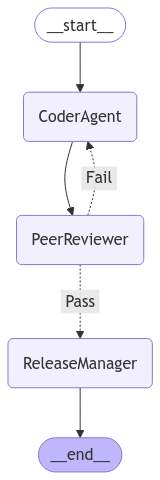

In [48]:
# Build Workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("CoderAgent", CoderAgent)
workflow.add_node("PeerReviewer", PeerReviewer)
workflow.add_node("ReleaseManager", ReleaseManager)

# # Add edges to connect nodes
workflow.add_edge(START, "CoderAgent")
workflow.add_edge("CoderAgent", "PeerReviewer")
workflow.add_conditional_edges("PeerReviewer", ReviewerCondition, {"Fail": "CoderAgent", "Pass": "ReleaseManager"})
workflow.add_edge("ReleaseManager", END)


# workflow.add_edge("coder", "peer_reviewer")
review_graph=workflow.compile()

# Show
display(Image(review_graph.get_graph().draw_mermaid_png()))

In [49]:
# Invoke
state = review_graph.invoke({"topic": "write a code to add two numbers"})

In [50]:
state

{'topic': 'write a code to add two numbers',
 'code': 'Based on the instruction provided, here is a Python code snippet that adds two numbers while adhering to best practices and fulfilling the given criteria:\n\n```python\ndef add_numbers(a, b):\n    """\n    Add two numbers and return the result.\n    \n    :param a: First number to add.\n    :param b: Second number to add.\n    :return: The sum of the two numbers.\n    :raises TypeError: If either of the inputs is not a number.\n    """\n    if not (isinstance(a, (int, float)) and isinstance(b, (int, float))):\n        raise TypeError("Both inputs must be numbers (int or float).")\n    \n    return a + b\n\n# Example usage:\nif __name__ == "__main__":\n    num1 = 5\n    num2 = 3.2\n    result = add_numbers(num1, num2)\n    print(f"The sum of {num1} and {num2} is {result}.")\n```\n\n### Explanation\n\n1. **Readability**: The function is named `add_numbers` which is descriptive of its purpose. The parameters `a` and `b` are straightfo